In [ ]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize

BACKTEST = 5
UPPER_BOUND = 0.4

In [ ]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

# tickers = ['SPY', 'SCHD', 'QQQ', 'VIG', 'VXUS']
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']

In [942]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  AAPL        MSFT        NVDA        GOOG        AMZN  \
Date                                                                     
2020-05-07   73.711327  175.738022    7.593772   68.304474  118.380501   
2020-05-08   75.465775  176.771744    7.783823   69.091255  118.980499   
2020-05-11   76.653259  178.743546    8.035895   69.832237  120.449997   
2020-05-12   75.777237  174.694672    7.773859   68.462738  117.847504   
2020-05-13   74.862297  172.052841    7.751441   67.148460  118.396004   
...                ...         ...         ...         ...         ...   
2025-04-29  211.210007  394.040009  109.019997  162.059998  187.389999   
2025-04-30  212.500000  395.260010  108.919998  160.889999  184.419998   
2025-05-01  213.320007  425.399994  111.610001  162.789993  190.199997   
2025-05-02  205.350006  435.279999  114.500000  165.809998  189.979996   
2025-05-05  198.889999  436.170013  113.820000  166.050003  186.350006   

                  META       BRK-B   

In [943]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [944]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           AAPL      MSFT      NVDA      GOOG      AMZN      META     BRK-B  \
AAPL   0.089080  0.054435  0.086056  0.053968  0.063184  0.068926  0.023466   
MSFT   0.054435  0.073714  0.092940  0.058303  0.066765  0.071200  0.018807   
NVDA   0.086056  0.092940  0.277871  0.090631  0.109360  0.119007  0.025228   
GOOG   0.053968  0.058303  0.090631  0.094802  0.072199  0.083277  0.022336   
AMZN   0.063184  0.066765  0.109360  0.072199  0.126469  0.097986  0.021592   
META   0.068926  0.071200  0.119007  0.083277  0.097986  0.198352  0.024380   
BRK-B  0.023466  0.018807  0.025228  0.022336  0.021592  0.024380  0.034235   
AVGO   0.060478  0.060346  0.142463  0.060189  0.072447  0.078465  0.021990   
TSM    0.051550  0.050508  0.133684  0.053676  0.062307  0.071050  0.018012   
WMT    0.019341  0.015891  0.020119  0.015614  0.020670  0.018885  0.012066   
LLY    0.020977  0.020295  0.032804  0.017893  0.020906  0.028520  0.013315   
JPM    0.024421  0.020429  0.036455  0.026321  0.026

In [945]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [946]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [947]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [ ]:
from fredapi import Fred
fred = Fred(api_key = '')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_23527/1429742868.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [949]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [950]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [951]:
optimal_weights = optimized_results.x #.x gets the results

In [952]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AAPL: 0.0000
MSFT: 0.0000
NVDA: 0.0957
GOOG: 0.0000
AMZN: 0.0000
META: 0.0000
BRK-B: 0.3440
AVGO: 0.1191
TSM: 0.0000
WMT: 0.1766
LLY: 0.2646
JPM: 0.0000
Expected Annual Return: 0.3050
Expected Volatility: 0.1836
Sharpe Ratio: 1.4278


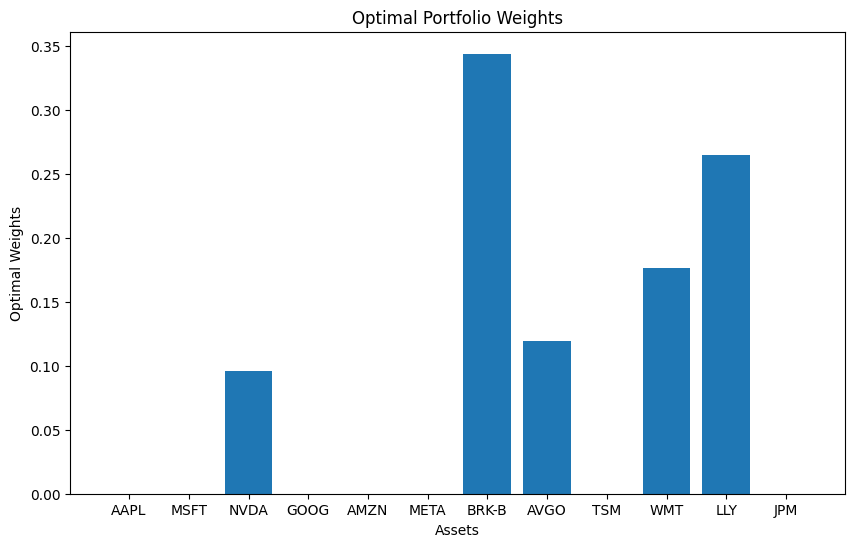

In [953]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()